In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from skimage import data, color, graph, filters, io
from skimage.util import img_as_float32
from skimage.segmentation import quickshift, mark_boundaries, expand_labels
from skimage.transform import rescale

# from sklearn.utils import shuffle
from sklearn.cluster import MeanShift, KMeans, estimate_bandwidth

import os.path as osp

In [243]:
def extract_feat(image: np.ndarray) -> pd.DataFrame:
    image_data = np.ndarray((image.shape[0] * image.shape[1], 5))
    for i, row in enumerate(image):
        for j, value in enumerate(row):
            image_data[i * image.shape[1] + j] = [*value, i, j]
    return pd.DataFrame(image_data, columns=['R', 'G', 'B', 'x', 'y']).\
           astype({'x': 'int64', 'y': 'int64'})
def label_image(flattened_image: pd.DataFrame, labels: np.ndarray) -> np.ndarray:
    max_x = int(flattened_image.max()['x'])
    max_y = int(flattened_image.max()['y'])
    image_labels = np.ndarray((max_x + 1, max_y + 1), dtype=np.int64)
    for i, row in flattened_image.iterrows():
        image_labels[int(row['x']), int(row['y'])] = labels[i]
    return image_labels
def label_to_rgb(image, labels, boundaries = True):
    result = color.label2rgb(labels, image,
                             kind='avg', bg_label=-1,
                             image_alpha=0, alpha=1)
    if boundaries: result = mark_boundaries(result, labels)
    return result
def show_ax(ax, title, image):
    ax.imshow(image)
    ax.set_axis_off()
    ax.set_title(title, fontsize=12)
    return ax

In [110]:
def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (
        graph.nodes[dst]['total color'] / graph.nodes[dst]['pixel count']
    )

In [91]:
# image is stored as arrays of pixels, pixel might be represented in
# different variety of colourspace. data.camera() for example is 
# gray-scale, hence each pixel is a value of lightness.
# data.astronaut() is colored, each pixel is instead a vector in RGB space 
# image = img_as_float32(data.astronaut())
image = img_as_float32(io.imread(osp.join('.', 'images', 'road.jpg')))
image.shape

(400, 600, 3)

In [15]:
image = rescale(image, [0.5, 0.5, 1])
image.shape

(384, 683, 3)

In [184]:
image_df = extract_feat(image)
# shuffled_sample = shuffle(image_df, random_state=0)
train = image_df[['R', 'G', 'B']]

In [92]:
labels = quickshift(image, kernel_size=3, max_dist=6, ratio=0.5, convert2lab=False)
labels

array([[ 23,  23,  23, ...,  16,  16,  16],
       [ 23,  23,  23, ...,  16,  16,  16],
       [ 23,  23,  23, ...,  16,  16,  16],
       ...,
       [706, 706, 706, ..., 720, 720, 720],
       [706, 706, 706, ..., 720, 720, 720],
       [706, 706, 706, ..., 720, 720, 720]])

## Mean Shift stuff

In [185]:
bandwidth = estimate_bandwidth(train, n_samples=1000, quantile=.6, random_state=0)
bandwidth

np.float64(0.592868914285297)

In [231]:
mean_shift = MeanShift(bandwidth=0.2, bin_seeding=True, max_iter=500, cluster_all=False)
ms_label = mean_shift.fit_predict(train)
ms_label = label_image(image_df, ms_label)
print('clusters:', len(np.unique(ms_label)))
ms_label

clusters: 6


array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1]])

## K-Means Stuff

In [232]:
kmean = KMeans(n_clusters=6, random_state=0)
km_label = kmean.fit_predict(train)
km_label = label_image(image_df, km_label)
km_label

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 4, 4, 4],
       [0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3]])

## Visualisation stuff

In [233]:
ms_rag = graph.rag_mean_color(image, ms_label, mode='distance', sigma=100)
km_rag = graph.rag_mean_color(image, km_label, mode='distance', sigma=100)
# edges = filters.sobel(color.rgb2gray(image))
# rag = graph.rag_boundary(labels, edges)

In [234]:
# labels2 = graph.cut_threshold(labels, rag, 0.99, in_place=False)
# labels2 = graph.cut_normalized(labels, rag, thresh=0.5, in_place=False)
ms_label2 = graph.merge_hierarchical(ms_label, ms_rag,
                                     thresh=0.7, # larger thresh -> less classes
                                     rag_copy=True,
                                     in_place_merge=False,
                                     merge_func=merge_mean_color,
                                     weight_func=_weight_mean_color)
km_label2 = graph.merge_hierarchical(km_label, km_rag,
                                     thresh=0.7,
                                     rag_copy=True,
                                     in_place_merge=False,
                                     merge_func=merge_mean_color,
                                     weight_func=_weight_mean_color)
# labels2 = expand_labels(labels, distance=0.005)
# labels2 = labels
print(len(np.unique(ms_label2)), len(np.unique(km_label2)))

2 2


In [244]:
do_bound = True
ms_outs = [label_to_rgb(image, ms_label, boundaries=do_bound),
           label_to_rgb(image, ms_label2, boundaries=do_bound)]
km_outs = [label_to_rgb(image, km_label, boundaries=do_bound),
           label_to_rgb(image, km_label2, boundaries=do_bound)]

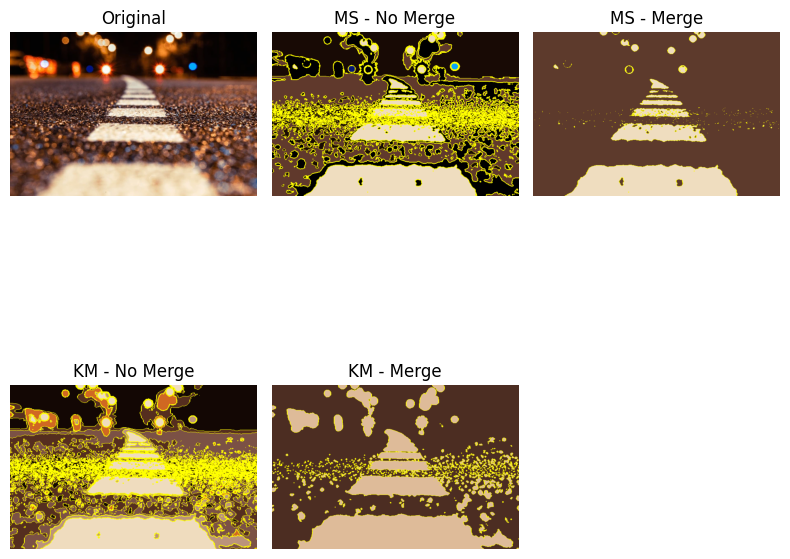

In [245]:
fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_subplot(231)
ax_ms1 = fig.add_subplot(232)
ax_ms2 = fig.add_subplot(233)
ax_km1 = fig.add_subplot(234)
ax_km2 = fig.add_subplot(235)

show_ax(ax1, 'Original', image)
show_ax(ax_ms1, 'MS - No Merge', ms_outs[0])
show_ax(ax_ms2, 'MS - Merge', ms_outs[1])
show_ax(ax_km1, 'KM - No Merge', km_outs[0])
show_ax(ax_km2, 'KM - Merge', km_outs[1])

fig.tight_layout()
plt.show()